In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.base import clone
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from tspiral.model_selection import TemporalSplit
from tspiral.forecasting import ForecastingCascade

from datasetsforecast.m3 import M3
from datasetsforecast.m4 import M4

In [3]:
### LOAD M3 AND M4 DATASETS ###

df_m4, _, _ = M4.load(directory='./', group='Monthly')
df_m3, _, _ = M3.load(directory='./', group='Monthly')

df_m4['unique_id'] = df_m4['unique_id'].factorize()[0]
df_m3['unique_id'] = df_m3['unique_id'].factorize()[0]

df_m3.shape, df_m4.shape

91.7MiB [00:02, 36.3MiB/s]
7.94MiB [00:00, 31.4MiB/s]
4.34MiB [00:00, 53.6MiB/s]                 
100%|██████████| 3.56M/3.56M [00:00<00:00, 33.0MiB/s]
100%|██████████| 1.76M/1.76M [00:00<00:00, 4.27MiB/s]
/opt/conda/lib/python3.10/site-packages/datasetsforecast/m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)


((167562, 3), (11246411, 3))

In [4]:
### INSTANTIATE MODELS AND FIT ###

sgd = ForecastingCascade(
    SGDRegressor(random_state=42),
    lags=range(1,12+1),
    groups=[0],
    target_standardize=True,
).fit(df_m4[['unique_id']], df_m4['y'])

lgbm = ForecastingCascade(
    lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=0),
    lags=range(1,12+1),
    groups=[0],
    target_standardize=True,
).fit(df_m4[['unique_id']], df_m4['y'])

In [5]:
### MAKE ROLLING FORECASTING AND STORE PREDICTIONS ###

CV = TemporalSplit(4, test_size=12, gap=12)


preds = []
for i, (train_id, test_id) in enumerate(CV.split(df_m3['y'], None, df_m3['unique_id'])):
    
    preds.append(
        df_m3.iloc[test_id].assign(
            cv_fold=i+1,
            lgbm_specific=clone(lgbm).fit(
                df_m3[['unique_id']].iloc[train_id], 
                df_m3['y'].iloc[train_id]
            ).predict(
                X=df_m3[['unique_id']].iloc[test_id],
                last_X=df_m3[['unique_id']].iloc[train_id],
                last_y=df_m3['y'].iloc[train_id],
            ),
            lgbm_general=lgbm.predict(
                X=df_m3[['unique_id']].iloc[test_id],
                last_X=df_m3[['unique_id']].iloc[train_id],
                last_y=df_m3['y'].iloc[train_id],
            ),
            sgd_specific=clone(sgd).fit(
                df_m3[['unique_id']].iloc[train_id], 
                df_m3['y'].iloc[train_id]
            ).predict(
                X=df_m3[['unique_id']].iloc[test_id],
                last_X=df_m3[['unique_id']].iloc[train_id],
                last_y=df_m3['y'].iloc[train_id],
            ),
            sgd_general=sgd.predict(
                X=df_m3[['unique_id']].iloc[test_id],
                last_X=df_m3[['unique_id']].iloc[train_id],
                last_y=df_m3['y'].iloc[train_id],
            )
        ).merge(
            df_m3.iloc[train_id].groupby('unique_id').tail(12) \
                .groupby('unique_id', as_index=False)[['y']].mean(),
            on='unique_id', how='left', suffixes=('', 'dummy_mean')
        ).merge(
            df_m3.iloc[train_id].groupby('unique_id').tail(12) \
                .assign(ds=lambda x: x['ds']+pd.DateOffset(months=12)),
            on=['ds','unique_id'], how='left', suffixes=('', 'dummy_season_repeat')
        ).merge(
            df_m3.iloc[train_id].groupby('unique_id', as_index=False).last() \
                .drop(columns=['ds']),
            on=['unique_id'], how='left', suffixes=('', 'dummy_repeat')
        )
    )
    
    
preds = pd.concat(preds, axis=0, ignore_index=True).dropna()
preds.shape

(67116, 11)

In [6]:
### CREATE SCORES DATAFRAMES ###

df_scores = pd.concat([
    preds.groupby('cv_fold')[['y',c]].apply(
        lambda x: mean_squared_error(x['y'], x[c], squared=False)
    ).to_frame(name=c)
    for c in set(preds.columns).difference(set(df_m3.columns))
    if c != 'cv_fold'
], axis=1, ignore_index=False)

df_scores

,ydummy_season_repeat,ydummy_repeat,lgbm_general,ydummy_mean,lgbm_specific,sgd_specific,sgd_general
cv_fold,,,,,,,
1,1483.617058,1609.601274,1305.379854,1347.652872,1373.406338,1346.376614,1320.419168
2,1420.007938,1600.511056,1309.212787,1390.613613,1367.405487,1325.857992,1284.701665
3,1287.092985,1485.756749,1140.297097,1240.782918,1201.602438,1185.326402,1178.325751
4,1342.508899,1548.844135,1220.852711,1301.568892,1228.548700,1236.369017,1250.711488


In [7]:
### GET STATISTICS FROM SCORES DATAFRAME ###

scores = df_scores.agg(['mean','std']).T.sort_values(by=['mean']).T

scores

,lgbm_general,sgd_general,sgd_specific,lgbm_specific,ydummy_mean,ydummy_season_repeat,ydummy_repeat
mean,1243.935612,1258.539518,1273.482506,1292.740741,1320.154574,1383.306720,1561.178304
std,80.229393,60.577981,75.731218,90.385418,64.202596,86.276084,56.957271


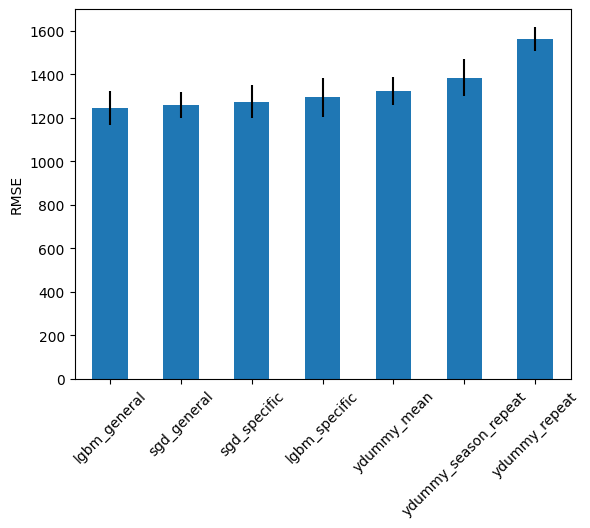

In [8]:
### PLOT SCORES ###

_ = scores.loc['mean'].plot.bar(yerr=scores.loc['std'], rot=45, ylabel='RMSE')